#  Neurobiological Correlates of ADHD: White Matter Integrity, Cortical Structure, and Exploratory Analysis of Alcohol Use

## 1. Imports and Paths


### Load Libraries

In [125]:
# general libraries
import os
import sys
import subprocess
import glob

# statistical and plotting libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

# neuroimaging libraries
import dipy, nilearn
import nibabel as nib
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.reconst.dti import TensorModel
from dipy.segment.mask import median_otsu
from nilearn.masking import compute_brain_mask

### Define Paths

In [126]:
# ----- PATHS -----
BIDS_ROOT = r"C:\Users\Om\Downloads\ds000030"  # folder with subset
PHENO_DIR = os.path.join(BIDS_ROOT, "phenotype")   
OUTPUT_DIR = os.path.join(BIDS_ROOT, "derivatives", "project_outputs")

os.makedirs(OUTPUT_DIR, exist_ok=True)
print(os.path.exists(BIDS_ROOT))
print(os.listdir(BIDS_ROOT)[:10])

# list subjects present in the subset
subjects = sorted(
    [
        d for d in os.listdir(BIDS_ROOT)
        if d.startswith("sub-") and os.path.isdir(os.path.join(BIDS_ROOT, d))
    ]
)


print(f"There are {len(subjects)} randomly selected subjects in the subset.")
print(subjects[:10])

True
['dataset_description.json', 'derivatives', 'ds000030_imaging_summary.csv', 'participants.tsv', 'phenotype', 'sub-10159', 'sub-10171', 'sub-10189', 'sub-10193', 'sub-10206']
There are 30 randomly selected subjects in the subset.
['sub-10159', 'sub-10171', 'sub-10189', 'sub-10193', 'sub-10206', 'sub-10217', 'sub-10225', 'sub-10227', 'sub-10228', 'sub-10235']


## 2. Load & Read datasets

### Participants Data

In [127]:
# load participants file

participants_path = os.path.join(BIDS_ROOT, "participants.tsv")
participants = pd.read_csv(participants_path, sep="\t")

print(participants.shape)
participants.head()

(272, 16)


,participant_id,diagnosis,age,gender,bart,bht,dwi,pamenc,pamret,rest,scap,stopsignal,T1w,taskswitch,ScannerSerialNumber,ghost_NoGhost
0,sub-10159,CONTROL,30,F,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,35343.0,No_ghost
1,sub-10171,CONTROL,24,M,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,35343.0,No_ghost
2,sub-10189,CONTROL,49,M,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,35343.0,No_ghost
3,sub-10193,CONTROL,40,M,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,35343.0,No_ghost
4,sub-10206,CONTROL,21,M,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,35343.0,No_ghost


### Demographic Data

In [128]:
# load demographic data

demo = pd.read_csv(os.path.join(BIDS_ROOT, "phenotype", "demographics.tsv"), sep="\t")
demo = demo[['participant_id', 'age', 'gender']]
print(demo.shape)

(272, 3)


### Alcohol Data

In [129]:

# SCID: Alcohol Variables (Lifetime Dependence + Any Alcohol Use)

scid_path = os.path.join(PHENO_DIR, "scid.tsv")
scid = pd.read_csv(scid_path, sep="\t")

print("Loaded SCID shape:", scid.shape)
print("First few SCID IDs:\n", scid['participant_id'].head())

# make sure participant_id is string and already matches "sub-XXXXX" format
scid['participant_id'] = scid['participant_id'].astype(str)

# identify relevant SCID columns
dep_cols = [c for c in scid.columns if c.startswith("scid_dep")]
alc_cols = [c for c in scid.columns if c.startswith("scid_alc")]

print("Dep columns:", dep_cols)
print("Alc columns:", alc_cols)

# convert to numeric (SCID codes are 1,2,3,... or missing)
scid[dep_cols] = scid[dep_cols].apply(pd.to_numeric, errors="coerce")
scid[alc_cols] = scid[alc_cols].apply(pd.to_numeric, errors="coerce")

# lifetime alcohol dependence indicator
# 1 if ANY of the scid_dep* fields is non-missing (such as some alcohol/substance dependence coded)
scid["alcohol_dependence"] = scid[dep_cols].notna().any(axis=1).astype(int)

# any alcohol-related diagnosis indicator (current or past)
# scid_alc* codes:
    # 1 = Current, 2 = Past
    # treat either as "has/had an alcohol-related diagnosis"
def _any_alcohol(row):
    # row is a Series of scid_alc* values (float with NaNs)
    vals = [v for v in row.values if pd.notna(v)]
    return int(any(v in (1, 2) for v in vals))

if len(alc_cols) > 0:
    scid["alcohol_any"] = scid[alc_cols].apply(_any_alcohol, axis=1)
else:
    # fallback: if no alc columns found, set alcohol_any = 0
    scid["alcohol_any"] = 0

# keep only what we need for merging
scid_for_merge = scid[["participant_id", "alcohol_dependence", "alcohol_any"]].copy()

ALCOHOL_COL = "alcohol_dependence"   # main variable for models

print(scid_for_merge.head())
print("Value counts for alcohol_dependence:\n", scid_for_merge["alcohol_dependence"].value_counts())
print("Value counts for alcohol_any:\n", scid_for_merge["alcohol_any"].value_counts())


Loaded SCID shape: (272, 57)
First few SCID IDs:
 0    sub-10159
1    sub-10171
2    sub-10189
3    sub-10193
4    sub-10206
Name: participant_id, dtype: object
Dep columns: ['scid_dep3', 'scid_dep5', 'scid_dep1', 'scid_dep7', 'scid_dep2', 'scid_dep4', 'scid_dep8', 'scid_dep6']
Alc columns: ['scid_alc2', 'scid_alc5', 'scid_alc1', 'scid_alc7', 'scid_alc8', 'scid_alc6', 'scid_alc3', 'scid_alc4']
  participant_id  alcohol_dependence  alcohol_any
0      sub-10159                   0            0
1      sub-10171                   0            1
2      sub-10189                   1            1
3      sub-10193                   0            1
4      sub-10206                   0            0
Value counts for alcohol_dependence:
 alcohol_dependence
0    188
1     84
Name: count, dtype: int64
Value counts for alcohol_any:
 alcohol_any
1    163
0    109
Name: count, dtype: int64


### ADHD Data

In [130]:
# load and compute total ADHD score (use ASRS items)

# load ADHD file
asrs = pd.read_csv(os.path.join(BIDS_ROOT, "phenotype", "asrs.tsv"), sep="\t")
asrs[['participant_id', 'asrs_score']].describe()

,asrs_score
count,272.000000
mean,10.783088
std,4.600739
min,0.000000
25%,8.000000
50%,10.000000
75%,14.000000
max,23.000000


## 3. Imaging QC & Extraction (DTI & T1)

In [131]:
# check for DWI and T1w files for each subject
import glob

results = []

for sub in subjects:
    dwi_path = glob.glob(os.path.join(BIDS_ROOT, sub, "dwi", "*dwi.nii.gz"))
    t1_path = glob.glob(os.path.join(BIDS_ROOT, sub, "anat", "*T1w.nii.gz"))

    results.append({
        "subject": sub,
        "has_dwi": bool(dwi_path),
        "has_t1": bool(t1_path)
    })

check_df = pd.DataFrame(results)
check_df

,subject,has_dwi,has_t1
0,sub-10159,True,True
1,sub-10171,True,True
2,sub-10189,True,True
3,sub-10193,True,True
4,sub-10206,True,True
5,sub-10217,True,True
6,sub-10225,True,True
7,sub-10227,True,True
8,sub-10228,True,True
9,sub-10235,True,True


### DTI Extraction

In [132]:
# run the DTI extraction pipeline

dti_rows = []

for sub in subjects:
    dwi_dir = os.path.join(BIDS_ROOT, sub, "dwi")
    if not os.path.isdir(dwi_dir):
        continue

    dwi_file = glob.glob(os.path.join(dwi_dir, "*dwi.nii.gz"))
    bval_file = glob.glob(os.path.join(dwi_dir, "*.bval"))
    bvec_file = glob.glob(os.path.join(dwi_dir, "*.bvec"))

    if not dwi_file or not bval_file or not bvec_file:
        continue

    dwi_file = dwi_file[0]
    bval_file = bval_file[0]
    bvec_file = bvec_file[0]

    print(f"Processing DTI for: {sub}")

    # load DWI data
    img = nib.load(dwi_file)
    data = img.get_fdata()

    # load bvals & bvecs
    bvals, bvecs = read_bvals_bvecs(bval_file, bvec_file)
    gtab = gradient_table(bvals, bvecs)

    # make mask
    b0_idx = np.where(bvals < 50)[0][:5]  # adjusted to take up to 5 B0 volumes
    # checks if any b0 volumes are found
    if len(b0_idx) == 0:
        print(f"No b0 volumes found for {sub}, skipping.")
        continue
    b0_idx = b0_idx[:5]
    data_masked, mask = median_otsu(data, vol_idx=b0_idx, median_radius=3)

    # fit tensor
    tenmodel = TensorModel(gtab)
    tenfit = tenmodel.fit(data_masked)

    FA = tenfit.fa[mask]
    MD = tenfit.md[mask]

    dti_rows.append({
        "participant_id": sub,
        "FA_mean": np.nanmean(FA),
        "FA_std": np.nanstd(FA),
        "MD_mean": np.nanmean(MD),
        "MD_std": np.nanstd(MD),
    })

dti_df = pd.DataFrame(dti_rows)
print("Finished DTI extraction for", len(dti_df), "subjects.", "Shape:", dti_df.shape, ".")
dti_df.head()

Processing DTI for: sub-10159


C:\Users\Om\AppData\Local\Temp\ipykernel_33564\2360008744.py:29: UserWarning: Pass ['bvecs'] as keyword args. From version 2.0.0 passing these as positional arguments will result in an error. 
  gtab = gradient_table(bvals, bvecs)


Processing DTI for: sub-10171
Processing DTI for: sub-10189
Processing DTI for: sub-10193
Processing DTI for: sub-10206
Processing DTI for: sub-10217
Processing DTI for: sub-10225
Processing DTI for: sub-10227
Processing DTI for: sub-10228
Processing DTI for: sub-10235
Processing DTI for: sub-10249
Processing DTI for: sub-10269
Processing DTI for: sub-10271
Processing DTI for: sub-10273
Processing DTI for: sub-10274
Processing DTI for: sub-10280
Processing DTI for: sub-10290
Processing DTI for: sub-10292
Processing DTI for: sub-10304
Processing DTI for: sub-10316
Processing DTI for: sub-10321
Processing DTI for: sub-10325
Processing DTI for: sub-10329
Processing DTI for: sub-10339
Processing DTI for: sub-10340
Processing DTI for: sub-10345
Processing DTI for: sub-10347
Processing DTI for: sub-10356
Processing DTI for: sub-10361
Finished DTI extraction for 29 subjects. Shape: (29, 5) .


,participant_id,FA_mean,FA_std,MD_mean,MD_std
0,sub-10159,0.273309,0.186462,0.001234,0.028507
1,sub-10171,0.281790,0.180784,0.003111,0.595167
2,sub-10189,0.294592,0.208202,0.001809,0.184492
3,sub-10193,0.291958,0.187145,0.001936,0.367186
4,sub-10206,0.301557,0.206244,0.007742,0.793167


### T1 Extraction

In [133]:
# run the T1 structural summary extraction

from nilearn.image import load_img

t1_rows = []

for sub in subjects:
    anat_dir = os.path.join(BIDS_ROOT, sub, "anat")
    if not os.path.isdir(anat_dir):
        continue

    t1_files = glob.glob(os.path.join(anat_dir, "*T1w.nii.gz"))
    if not t1_files:
        continue

    t1_file = t1_files[0]
    print(f"Processing T1 for: {sub}")

    # load T1 image
    img = load_img(t1_file)
    data = img.get_fdata()

    # compute brain mask vota thresholding
    mask = compute_brain_mask(img).get_fdata().astype(bool)
    brain = data[mask]

    t1_rows.append({
        "participant_id": sub,
        "T1_mean_intensity": np.nanmean(brain),
        "T1_intensity_std": np.nanstd(brain),
        "T1_brain_voxels": mask.sum(),
    })

t1_df = pd.DataFrame(t1_rows)
print("Finished T1 extraction for:", len(t1_df), ". Shape:", t1_df.shape)
t1_df.head()

Processing T1 for: sub-10159
Processing T1 for: sub-10171
Processing T1 for: sub-10189
Processing T1 for: sub-10193
Processing T1 for: sub-10206
Processing T1 for: sub-10217
Processing T1 for: sub-10225
Processing T1 for: sub-10227
Processing T1 for: sub-10228
Processing T1 for: sub-10235
Processing T1 for: sub-10249
Processing T1 for: sub-10269
Processing T1 for: sub-10271
Processing T1 for: sub-10273
Processing T1 for: sub-10274
Processing T1 for: sub-10280
Processing T1 for: sub-10290
Processing T1 for: sub-10292
Processing T1 for: sub-10304
Processing T1 for: sub-10316
Processing T1 for: sub-10321
Processing T1 for: sub-10325
Processing T1 for: sub-10329
Processing T1 for: sub-10339
Processing T1 for: sub-10340
Processing T1 for: sub-10345
Processing T1 for: sub-10347
Processing T1 for: sub-10356
Processing T1 for: sub-10361
Finished T1 extraction for: 29 . Shape: (29, 4)


,participant_id,T1_mean_intensity,T1_intensity_std,T1_brain_voxels
0,sub-10159,170.968172,112.531091,1744178
1,sub-10171,212.783081,107.436499,1746057
2,sub-10189,196.732095,108.642027,1747344
3,sub-10193,192.997534,120.622495,1745311
4,sub-10206,143.544189,110.524947,1746005


## 4. Merge & Clean Analysis Dataset

In [134]:
# combine DTI and T1 summaries into one dataframe

imaging_df = pd.merge(dti_df, t1_df, on="participant_id", how="outer")
print(imaging_df.shape)
imaging_df.head()

out_path = os.path.join(BIDS_ROOT, "ds000030_imaging_summary.csv")
imaging_df.to_csv(out_path, index=False)
print("Saved:", out_path)

(29, 8)
Saved: C:\Users\Om\Downloads\ds000030\ds000030_imaging_summary.csv


In [135]:
imaging_file = os.path.join(BIDS_ROOT, "ds000030_imaging_summary.csv")

IMAGING_COLS = ["FA_mean", "MD_mean", "T1_mean_intensity"]

# load imaging summary file
imaging_df = pd.read_csv(imaging_file)
imaging_df.head()

,participant_id,FA_mean,FA_std,MD_mean,MD_std,T1_mean_intensity,T1_intensity_std,T1_brain_voxels
0,sub-10159,0.273309,0.186462,0.001234,0.028507,170.968172,112.531091,1744178
1,sub-10171,0.281790,0.180784,0.003111,0.595167,212.783081,107.436499,1746057
2,sub-10189,0.294592,0.208202,0.001809,0.184492,196.732095,108.642027,1747344
3,sub-10193,0.291958,0.187145,0.001936,0.367186,192.997534,120.622495,1745311
4,sub-10206,0.301557,0.206244,0.007742,0.793167,143.544189,110.524947,1746005


### Master Dataframe

In [136]:
# merge participants + ASRS (Adult ADHD Self-Report Scale) + alcohol + demographics + imaging

# keep only participant_id from participants
participants_core = participants[['participant_id']]

# ADHD via ASRS
ADHD_COL = 'asrs_score'
adhd_for_merge = asrs[['participant_id', 'asrs_score']]

# already defined:
    # demo
    # scid_for_merge
    # imaging_df

master = (
    participants_core
    .merge(demo, on='participant_id', how='left')
    .merge(scid_for_merge, on='participant_id', how='left')
    .merge(adhd_for_merge, on='participant_id', how='left')
    .merge(imaging_df, on='participant_id', how='left')
)

print("Master shape:", master.shape)
master.head()
print("Columns in master:", master.columns.tolist())
print(master[[ "participant_id", ALCOHOL_COL ]].head())
print(master[ALCOHOL_COL].value_counts(dropna=False))

Master shape: (272, 13)
Columns in master: ['participant_id', 'age', 'gender', 'alcohol_dependence', 'alcohol_any', 'asrs_score', 'FA_mean', 'FA_std', 'MD_mean', 'MD_std', 'T1_mean_intensity', 'T1_intensity_std', 'T1_brain_voxels']
  participant_id  alcohol_dependence
0      sub-10159                   0
1      sub-10171                   0
2      sub-10189                   1
3      sub-10193                   0
4      sub-10206                   0
alcohol_dependence
0    188
1     84
Name: count, dtype: int64


In [137]:
# drop rows with missing data in key columns

analysis_df = master.dropna(
    subset=[ADHD_COL, ALCOHOL_COL, 'age', 'gender'] + IMAGING_COLS
)

print("Analysis N:", len(analysis_df))
print(analysis_df[ALCOHOL_COL].value_counts())
analysis_df.head()

Analysis N: 29
alcohol_dependence
0    22
1     7
Name: count, dtype: int64


,participant_id,age,gender,alcohol_dependence,alcohol_any,asrs_score,FA_mean,FA_std,MD_mean,MD_std,T1_mean_intensity,T1_intensity_std,T1_brain_voxels
0,sub-10159,30.0,2.0,0,0,11,0.273309,0.186462,0.001234,0.028507,170.968172,112.531091,1744178.0
1,sub-10171,24.0,1.0,0,1,13,0.281790,0.180784,0.003111,0.595167,212.783081,107.436499,1746057.0
2,sub-10189,49.0,1.0,1,1,9,0.294592,0.208202,0.001809,0.184492,196.732095,108.642027,1747344.0
3,sub-10193,40.0,1.0,0,1,6,0.291958,0.187145,0.001936,0.367186,192.997534,120.622495,1745311.0
4,sub-10206,21.0,1.0,0,0,7,0.301557,0.206244,0.007742,0.793167,143.544189,110.524947,1746005.0


In [138]:
# save master and analysis dataframes for reproducibility

master.to_csv(os.path.join(OUTPUT_DIR, "master_dataset.csv"), index=False)
analysis_df.to_csv(os.path.join(OUTPUT_DIR, "analysis_dataset.csv"), index=False)

print("Saved master and analysis datasets.")

Saved master and analysis datasets.


## 5. Models

### Figure 1: Correlation Heatmap

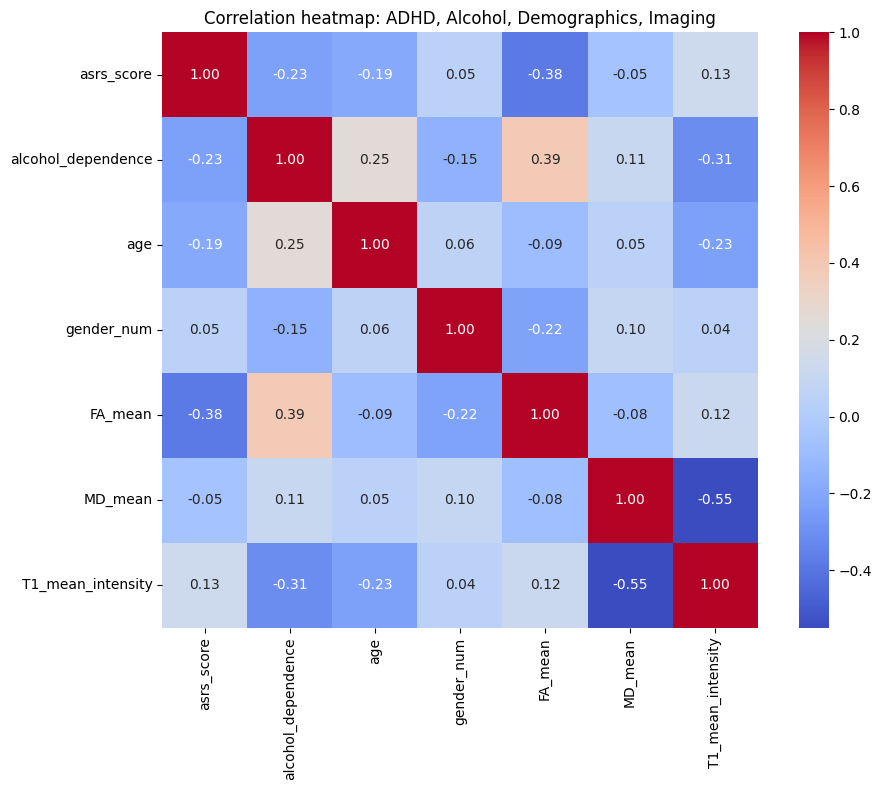

In [147]:
analysis_df = analysis_df.copy()
analysis_df.loc[:, 'FA_mean_c'] = analysis_df['FA_mean'] - analysis_df['FA_mean'].mean()
analysis_df.loc[:, 'Alcohol_FA_int'] = analysis_df[ALCOHOL_COL] * analysis_df['FA_mean_c']

if analysis_df['gender'].dtype == 'object':
    gender_map = {"M": 0, "F": 1}
    analysis_df["gender_num"] = analysis_df["gender"].map(gender_map)
else:
    analysis_df['gender_num'] = analysis_df['gender']

heatmap_vars = [
    ADHD_COL,
    ALCOHOL_COL,
    'age',
    'gender_num',
] + IMAGING_COLS

corr_df = analysis_df[heatmap_vars].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, fmt=".2f", square=True, cmap="coolwarm")
plt.title("Correlation heatmap: ADHD, Alcohol, Demographics, Imaging")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "corr_heatmap.png"), dpi=300)
plt.show()



### Table 1: Variance Inflation Factor (VIF)

In [140]:
# variables to test for collinearity (predictors only, not outcome)
vif_features = [
    ALCOHOL_COL,
    'age',
    'gender_num',
    "FA_mean",
    "MD_mean",
    "T1_mean_intensity",
]

X = analysis_df[vif_features].copy()

vif_results = []

for i, col in enumerate(vif_features):
    # target = this feature
    y = X[col].values.reshape(-1, 1)
    # predictors = all other features
    X_other = X.drop(columns=[col]).values

    model = LinearRegression()
    model.fit(X_other, y)
    r2 = model.score(X_other, y)
    vif = np.inf if r2 >= 1 else 1.0 / (1.0 - r2)
    vif_results.append({"variable": col, "R2": r2, "VIF": vif})

vif_df = pd.DataFrame(vif_results)
print(vif_df)
vif_df.to_csv(os.path.join(OUTPUT_DIR, "vif_results.csv"), index=False)

             variable        R2       VIF
0  alcohol_dependence  0.329870  1.492248
1                 age  0.131487  1.151393
2          gender_num  0.081338  1.088539
3             FA_mean  0.261550  1.354187
4             MD_mean  0.327674  1.487374
5   T1_mean_intensity  0.427384  1.746372


No multicollinearity problems -> max VIF = 1.75

### Regression Models

#### Helper for Regression Summaries

In [141]:
def run_linear_regression(df, y_col, x_cols, add_intercept=True):
    X = df[x_cols].copy()
    y = df[y_col].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    model = LinearRegression()
    model.fit(X_scaled, y)
    
    y_pred = model.predict(X_scaled)
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)

    coef_table = pd.DataFrame({
        "predictor": x_cols,
        "coef_standardized": model.coef_
    })

    return model, coef_table, r2, mse

#### Model 1: Alcohol Predicting ADHD (ASRS), with covariates

In [142]:
model1_predictors = [ALCOHOL_COL, 'age', 'gender_num']

model1, model1_coefs, model1_r2, model1_mse = run_linear_regression(
    analysis_df,
    y_col=ADHD_COL,
    x_cols=model1_predictors
)

print("Model 1: ADHD ~ alcohol_dependence + age + gender")
print(model1_coefs)
print(f"R^2 = {model1_r2:.3f}, MSE = {model1_mse:.3f}")

Model 1: ADHD ~ alcohol_dependence + age + gender
            predictor  coef_standardized
0  alcohol_dependence          -0.632242
1                 age          -0.472414
2          gender_num           0.087440
R^2 = 0.072, MSE = 10.237


#### Model 2: Imaging Predicting ADHD (ASRS), with covariates

In [143]:
model2_predictors = [
    'age',
    'gender_num',
    'FA_mean',
    'MD_mean',
    'T1_mean_intensity',
]

model2, model2_coefs, model2_r2, model2_mse = run_linear_regression(
    analysis_df,
    y_col=ADHD_COL,
    x_cols=model2_predictors
)

print("Model 2: ADHD ~ age + gender + FA_mean + MD_mean + T1_mean_intensity")
print(model2_coefs)
print(f"R^2 = {model2_r2:.3f}, MSE = {model2_mse:.3f}")

Model 2: ADHD ~ age + gender + FA_mean + MD_mean + T1_mean_intensity
           predictor  coef_standardized
0                age          -0.638763
1         gender_num          -0.145659
2            FA_mean          -1.423038
3            MD_mean           0.019395
4  T1_mean_intensity           0.484269
R^2 = 0.218, MSE = 8.626


#### Model 3: Alcohol * Fractional Anisotropy Mean

In [148]:
# interaction term
analysis_df['FA_mean_c'] = analysis_df['FA_mean'] - analysis_df['FA_mean'].mean()
analysis_df['Alcohol_FA_int'] = analysis_df[ALCOHOL_COL] * analysis_df['FA_mean_c']

model3_predictors = [
    ALCOHOL_COL,
    'FA_mean_c',
    'Alcohol_FA_int',
    'age',
    'gender_num',
]

model3, model3_coefs, model3_r2, model3_mse = run_linear_regression(
    analysis_df,
    y_col=ADHD_COL,
    x_cols=model3_predictors
)

print("Model 3: ADHD ~ alcohol_dependence * FA_mean_c + age + gender")
print(model3_coefs)
print(f"R^2 = {model3_r2:.3f}, MSE = {model3_mse:.3f}")


Model 3: ADHD ~ alcohol_dependence * FA_mean_c + age + gender
            predictor  coef_standardized
0  alcohol_dependence          -0.322050
1           FA_mean_c           2.760829
2      Alcohol_FA_int          -4.125718
3                 age          -0.884650
4          gender_num          -0.010559
R^2 = 0.285, MSE = 7.884


### Figure 2: Interaction Plot

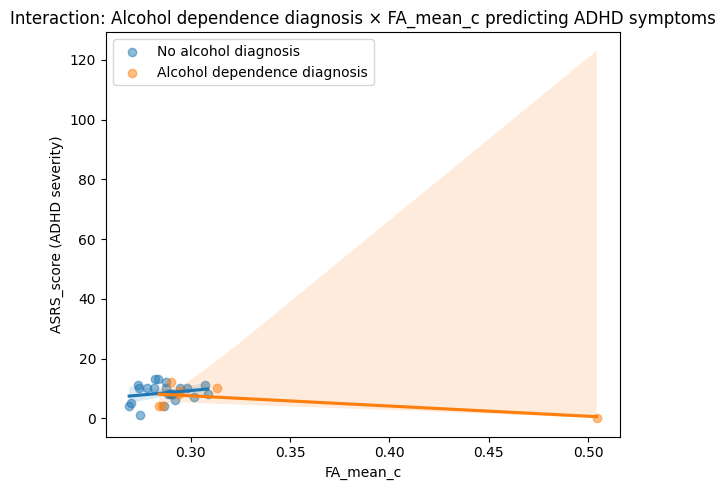

In [149]:
plt.figure(figsize=(6, 5))

# small noise adjusement for better visibility
df0 = analysis_df[analysis_df[ALCOHOL_COL] == 0]
df1 = analysis_df[analysis_df[ALCOHOL_COL] == 1]

sns.regplot(
    data=df0,
    x='FA_mean',
    y=ADHD_COL,
    scatter_kws={'alpha': 0.5},
    label='No alcohol diagnosis'
)

sns.regplot(
    data=df1,
    x='FA_mean',
    y=ADHD_COL,
    scatter_kws={'alpha': 0.5},
    label='Alcohol dependence diagnosis'
)

plt.xlabel('FA_mean_c')
plt.ylabel('ASRS_score (ADHD severity)')
plt.title('Interaction: Alcohol dependence diagnosis × FA_mean_c predicting ADHD symptoms')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "interaction_alcohol_dependence_FA_mean_c_ADHD.png"), dpi=300)
plt.show()
